# Supplementary Figure 5

**Summary:**

- **Panel a:** Measure of read length and alignment length across experiments.

- **Sup. Table 2.b:** Distribution of 5’ features identified in Pass/Fail reads.

- **Panel b:** Measure of read coverage.

---

<br>

## Import libraries

In [1]:
import pandas as pd
import numpy as np

import pysam

import matplotlib as mpl
import matplotlib.pyplot as plt
import joypy

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

In [4]:
runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6', 'SL1_1', 'NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']

In [5]:
colorlist = ['#90e4c1','#90e4c1','#90e4c1','#90e4c1','#90e4c1',             # NP experiments
             '#fdaa48',                                                     # SL1 experiment
             '#b790d4','#b790d4','#b790d4','#b790d4','#b790d4','#b790d4']   # SSP experiment

## Opening Dataset file

In [6]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [7]:
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

---

<br>

# Panel a: Measure of read length and alignment length across experiments

In [8]:
stats = dataset[['read', 'run', 'sequence_length', 'alignment_length']].copy()

# Measure mean and median read length
stats_df = pd.DataFrame()

for run in runs:
    s = stats[stats['run'] == run]
    stats_df.loc[run, 'total_reads'] = round(len(s['sequence_length']))
    stats_df.loc[run, 'mean_read_length'] = round(np.mean(s['sequence_length']))
    stats_df.loc[run, 'median_read_length'] = round(np.median(s['sequence_length']))

stats_df = stats_df.astype(int)

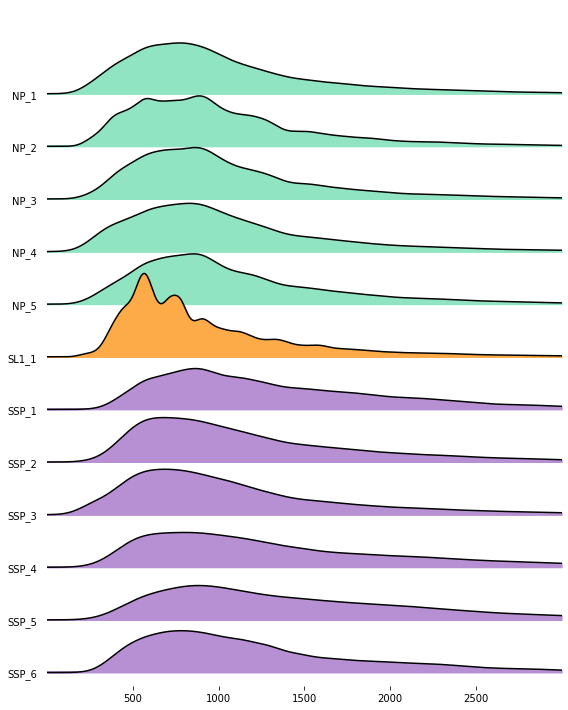

In [9]:
%matplotlib inline

fig, axes = joypy.joyplot(stats, by="run", column="sequence_length", figsize=(8, 10), title='',
                          x_range=[0, 3000], bins=[i for i in range(0,3000,20)], color=colorlist)

plt.savefig('SupFig5.a-joyplot_read_length.png', bbox_inches='tight', dpi=500)

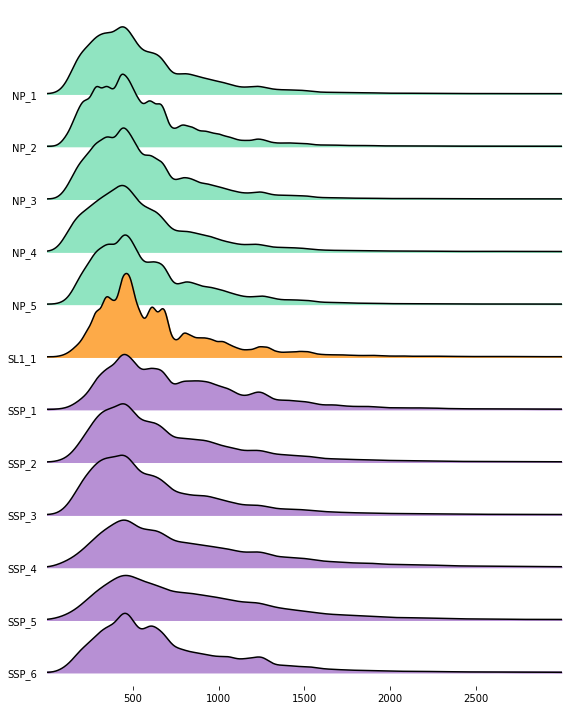

In [10]:
%matplotlib inline

fig, axes = joypy.joyplot(stats, by="run", column="alignment_length", figsize=(8, 10), title='',
                          x_range=[0, 3000], bins=[i for i in range(0,3000,20)], color=colorlist)

plt.savefig('SupFig5.a-joyplot_alignment_length.png', bbox_inches='tight', dpi=500)

<font size="4">**Sup. Fig 5.a:**<br></font>
Read length and Alignment length are plotted as a histogram for each sequencing experiment and depicted as a joyplot.

<br>

# Sup. Table 2.b: Distribution of 5’ features identified in Pass/Fail reads

In [11]:
# Retrieve reads clasified as Pass/Fail following basecalling from the sequencing summary file 
reads_summary = pd.DataFrame()

for ID in runs:

    file = f'{path}/{ID}/{ID}-sequencing_summary.txt'
    df = pd.read_csv(file, sep='\t')
    
    df = df[['read_id','passes_filtering']]
    df.columns = ['read', 'read_filtering']
    df.set_index('read')
    
    reads_summary = pd.concat([reads_summary, df], axis=0)
    
# split into two categories
passed = list(reads_summary[reads_summary['read_filtering'] == True]['read'])
failed = list(reads_summary[reads_summary['read_filtering'] == False]['read'])

# merge pass/fail classification with the main dataset table
pass_reads = dataset[dataset['read'].isin(passed)]
fail_reads = dataset[dataset['read'].isin(failed)]

In [12]:
# generate table to measure % of SL / Hairpin / non-ID reads
filtered_reads_stats =  pd.DataFrame()

for label, reads in {'Pass': pass_reads, 'Fail': fail_reads}.items():
    
    total = len(reads)
    
    _sl = list(reads[reads['ROBUST_SL_FOUND']=='FOUND']['read'])
    sl_percent = round(len(_sl)/total*100)
    
    _hairpin = list(reads[reads['HAIRPIN_FOUND']=='FOUND']['read'])
    hairpin_percent = round(len(_hairpin)/total*100)
    
    _nonID = reads[~reads['read'].isin(_sl+_hairpin)]
    nonID_percent = round(len(_nonID)/total*100)
    
    filtered_reads_stats.loc[label, 'total'] = total
    filtered_reads_stats.loc[label, 'SL'] = len(_sl)
    filtered_reads_stats.loc[label, 'hairpin'] = len(_hairpin)
    filtered_reads_stats.loc[label, 'nonId'] = len(_nonID)
    
    filtered_reads_stats.loc[label, '%SL'] = sl_percent
    filtered_reads_stats.loc[label, '%hairpin'] = hairpin_percent
    filtered_reads_stats.loc[label, '%nonID'] = nonID_percent
    
filtered_reads_stats = filtered_reads_stats.astype(int)

In [13]:
filtered_reads_stats

,total,SL,hairpin,nonId,%SL,%hairpin,%nonID
Pass,9915859,4864725,1122274,3928860,49,11,40
Fail,1224194,379062,141949,703183,31,12,57


<font size="4">**Sup. Table 2.b:**<br></font>
Distribution of 5’ features identified in Pass/Fail reads

<br>

# Panel b: Measure of read coverage

In [14]:
# Loop over one SAM file to retrieve and store reference transcript length 

file = f'{path}/SSP_1/SSP_1-transcriptome_sorted.bam'

with pysam.AlignmentFile(file,'rb') as alignments:
    ref_lengths = {}
    for ref, length in zip(alignments.references, alignments.lengths):
        if ref not in ref_lengths:
            ref_lengths[ref] = length

In [15]:
# prepare dataframe for computing coverage
coverage_stats = dataset[['read', 'gene', 'isoform', 'corrected_genomic_start', 'alignment_length']].copy()

# determine length of transcript
coverage_stats['transcript_length'] = coverage_stats['isoform'].map(ref_lengths)

# measure coverage
coverage_stats['coverage'] = round(coverage_stats['alignment_length']/coverage_stats['transcript_length']*100, 2)

In [16]:
# main start position as dataframe
main_tss = genes_start[genes_start['total']>0].sort_values(['total','SL'], ascending=False).groupby(['gene']).head(1).reset_index(drop=True)

# Dictionnary of main start positions
main_pos = main_tss.set_index('gene')['position'].to_dict()

In [17]:
df_list = []

for (gene, iso), subdataset in coverage_stats.groupby(['gene','isoform']):
    if gene in main_pos:
        pos = main_pos[gene]
        reads = subdataset[subdataset['corrected_genomic_start'] == pos]
        df_list.append(reads)
        
main_pos_coverage = pd.concat(df_list)

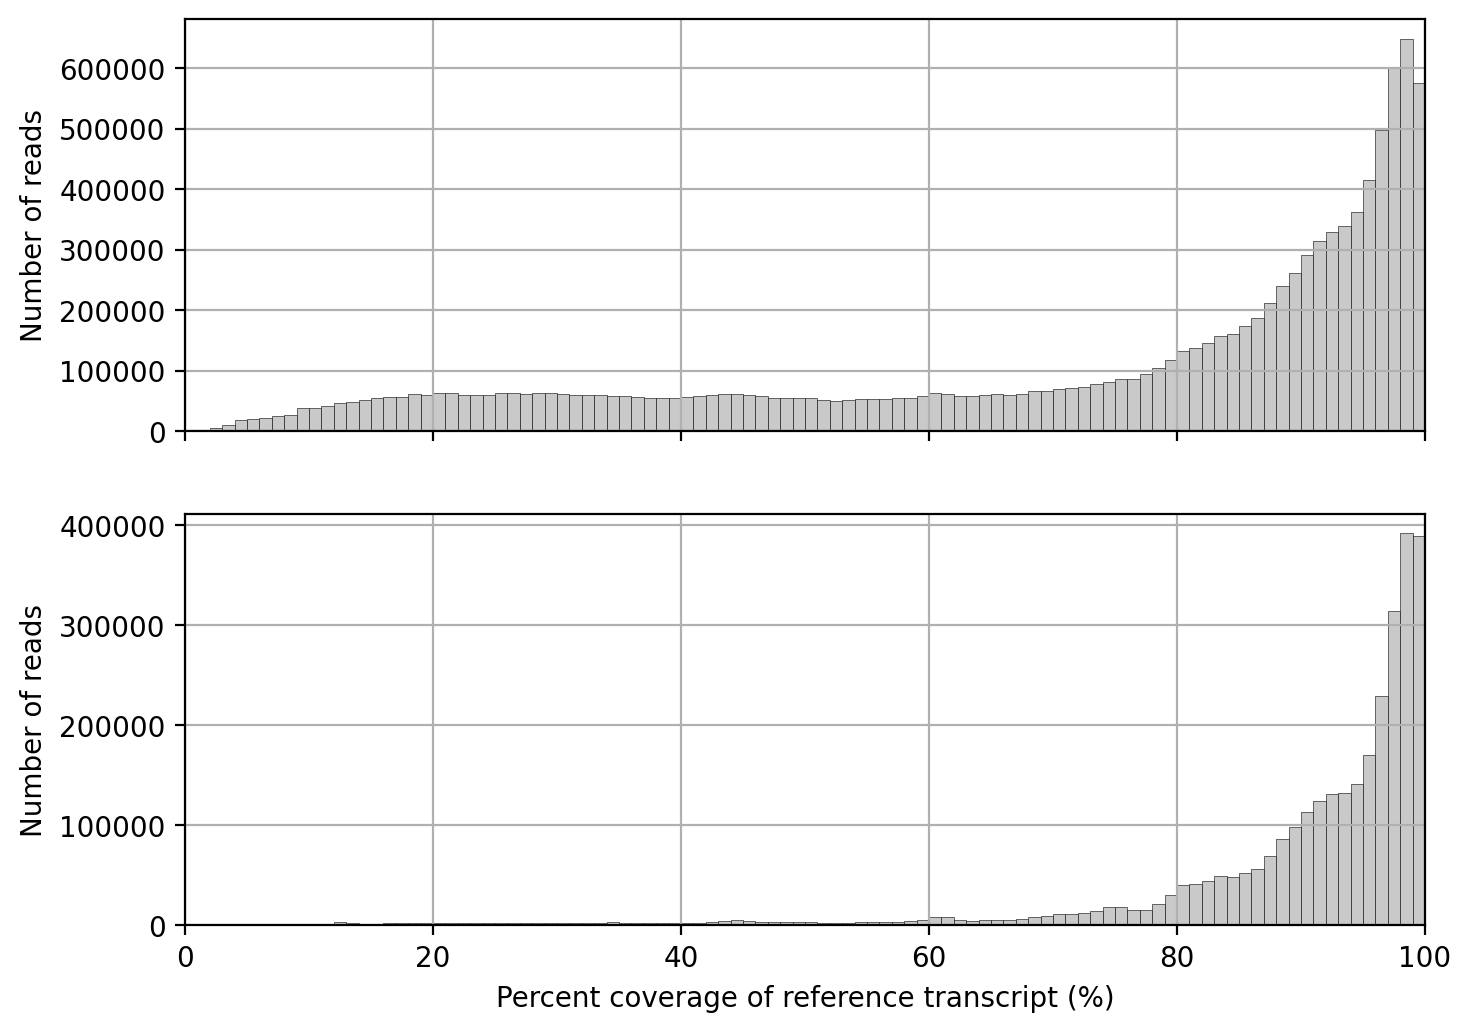

In [18]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6), dpi=200, nrows=2, ncols=1, sharex=True)

# All reads
n_coverage = len(coverage_stats['coverage'])
coverage_stats['coverage'].hist(ax=ax[0], bins=[i for i in range(0,101,1)], density=False,
                                label=f'All reads (n={n_coverage})',
                                color='#c9c9c9', edgecolor='k', linewidth=0.2, )

# Most expressed start positions
n_main_coverage = len(main_pos_coverage['coverage'])
main_pos_coverage['coverage'].hist(ax=ax[1], bins=[i for i in range(0,101,1)], density=False, 
                                   label=f'Reads at most expressed start position (n={n_main_coverage})',
                                   color='#c9c9c9', edgecolor='k', linewidth=0.2)

# plot settings
ax[0].set_ylabel('Number of reads')
ax[1].set_ylabel('Number of reads')
ax[1].set_xlabel('Percent coverage of reference transcript (%)')
plt.xlim(0,100)

plt.savefig('SupFig5.b-read_coverage_of_reference_trancripts.png', bbox_inches='tight', dpi=800)

<font size="4">**Sup. Fig 5.b:**<br></font>
We measured their coverage of their respective reference transcript. 
**Top Panel:** present the resulting distribution for all the reads. \
**bottom Panel:** present only for reads located at the most expressed position of each gene.